## Cargamos el contenido desde Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Confirmar que se dispone de una GPU

In [3]:
import tensorflow
tensorflow.test.gpu_device_name()

'/device:GPU:0'

## Comprobamos que se carga correctamente el dataset

earth  jupiter	mars  mercury  neptune	pluto  saturn  uranus  venus


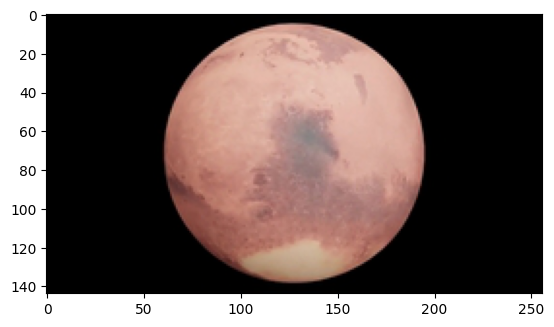

In [4]:
!ls "/content/drive/My Drive/Colab Notebooks/planetsdataset_completo/dataset/"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/planetsdataset_completo/dataset/mars/mars (27).jpg', 'r')
imshow(np.asarray(pil_im))

# **Data Agumentation**

In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, smart_resize
import glob

## Comprobamos cuantas imagenes faltan de cada planeta

In [6]:
images_increased = 286

# Lista que almacena las clases que tiene nuestro dataset
planets = ["earth", "jupiter", "mars", "mercury", "neptune", "pluto", "saturn", "uranus", "venus"]

data_path = "/content/drive/My Drive/Colab Notebooks/planetsdataset_completo/dataset/"  # Directorio del data set

missing_photos = 0

for planet in planets:
    dir = data_path + planet
    total_images = len(os.listdir(dir))
    if (total_images >= images_increased):
        print("Hay " + str(total_images) + " fotos de " + planet + " y son suficientes")
    else:
        resting_images = images_increased - total_images
        missing_photos += resting_images + 1
        print("Hay " + str(total_images) + " fotos de " + planet + " y faltan " + str(resting_images+1))

print("Faltan ", missing_photos, " en total")

Hay 297 fotos de earth y son suficientes
Hay 269 fotos de jupiter y faltan 18
Hay 306 fotos de mars y son suficientes
Hay 174 fotos de mercury y faltan 113
Hay 252 fotos de neptune y faltan 35
Hay 193 fotos de pluto y faltan 94
Hay 220 fotos de saturn y faltan 67
Hay 155 fotos de uranus y faltan 132
Hay 164 fotos de venus y faltan 123
Faltan  582  en total


## Creamos el modelo con el cual haremos el data augmentation

In [7]:
train_datagen = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=15,
    zoom_range=0.1,
    fill_mode="nearest")

## Aumentamos las imagenes necesarias para cada planeta

In [8]:
num_images = 0

for planet in planets:
    dir = data_path + planet
    total_images = len(os.listdir(dir))
    if (total_images >= images_increased):
        print("Hay " + str(total_images) + " fotos de " + planet + " y son suficientes")
    else:
      for i in range(1, total_images, 1):
        for name in glob.glob(str(data_path) + str(planet) + "/" + str(planet) + " (" + str(i) + ").jpg"):
          if total_images >= images_increased+1:
              break
          img = load_img(name)  # Cargamos la imagen
          x = img_to_array(img)  # Convertimos la imagen a un array
          x = x.reshape((1,) + x.shape)
          j = 0
          for batch in train_datagen.flow(x, batch_size = 1,
                                         save_to_dir = str(data_path) + str(planet),
                                         save_prefix = str(planet) + " (" + str(total_images) + ")", save_format = 'jpg'):
          # Se aplica la generacion de imagenes y se guardan directamente en el directorio save_to_dir y en el formato save_format
            total_images += 1
            j += 1
            num_images += 1
            if j >= 0:
              break

print("Images generates: ", num_images)
if (missing_photos == num_images):
  print("Se ha suplido el deficit de imagenes")

Hay 297 fotos de earth y son suficientes
Hay 306 fotos de mars y son suficientes
Images generates:  582
Se ha suplido el deficit de imagenes


# Reorganizamos las fotos en los directorios correspondientes

In [9]:
import random
import shutil

global_dir = "/content/drive/My Drive/Colab Notebooks/planetsdataset_completo/" # Directorio Global del data set

for planet in planets:

    images = os.listdir(global_dir + "dataset/" + planet + "/")  # Guardamos todas las imágenes por planeta que hay en el dataset
    num_imgs = len(images) # Número total de imágenes
    num_test = int(num_imgs*0.1) # Número de fotos que se destinan a test
    num_validation = int(num_imgs*0.2) # Número de fotos que se destinan a validación

    chosen = random.sample(images, num_test)  # Elegimos num_test imágenes de forma aleatoria sin que se repita ninguna
    for choice in chosen: # Movemos todas las imágenes seleccionadas a la carpeta de test
        x = choice.split(")")
        x.pop()
        name = x[0] + ").jpg" # Damos formato al nombre del nuevo archivo
        shutil.move(global_dir + "dataset/" + planet + "/" + choice, global_dir + "test/" + planet + "/" + name)

    images = os.listdir(global_dir + "dataset/" + planet + "/") # Guardamos las imágenes restantes por planeta que hay en el dataset
    chosen = random.sample(images, num_validation) # Elegimos num_validation imágenes de forma aleatoria sin que se repita ninguna
    for choice in chosen: # Movemos todas las imágenes seleccionadas a la carpeta de validation
        x = choice.split(")")
        x.pop()
        name = x[0] + ").jpg" # Damos formato al nombre del nuevo archivo
        shutil.move(global_dir + "dataset/" + planet + "/" + choice, global_dir + "validation/" + planet + "/" + name)

    images = os.listdir(global_dir + "dataset/" + planet + "/") # Guardamos las imágenes restantes por planeta que hay en el dataset
    for image in images: # Movemos todas las imágenes a la carpeta de training
        x = image.split(")")
        x.pop()
        name = x[0] + ").jpg" # Damos formato al nombre del nuevo archivo
        shutil.move(global_dir + "dataset/" + planet + "/" + image, global_dir + "training/" + planet + "/" + name)

shutil.rmtree(global_dir + "dataset/") # Eliminamos el directorio "dataset" y sus hijos

print("\n")
for planet in planets:
    print("Fotos de entrenamiento de", planet, ": ", len(os.listdir(global_dir + "training/" + planet + "/")))
print("\n====================================================================\n")
for planet in planets:
    print("Fotos de validación de", planet, ": ", len(os.listdir(global_dir + "validation/" + planet + "/")))
print("\n====================================================================\n")
for planet in planets:
    print("Fotos de test de", planet, ": ", len(os.listdir(global_dir + "test/" + planet + "/")))



Fotos de entrenamiento de earth :  209
Fotos de entrenamiento de jupiter :  202
Fotos de entrenamiento de mars :  215
Fotos de entrenamiento de mercury :  201
Fotos de entrenamiento de neptune :  202
Fotos de entrenamiento de pluto :  201
Fotos de entrenamiento de saturn :  201
Fotos de entrenamiento de uranus :  202
Fotos de entrenamiento de venus :  201


Fotos de validación de earth :  59
Fotos de validación de jupiter :  57
Fotos de validación de mars :  61
Fotos de validación de mercury :  57
Fotos de validación de neptune :  57
Fotos de validación de pluto :  57
Fotos de validación de saturn :  57
Fotos de validación de uranus :  57
Fotos de validación de venus :  57


Fotos de test de earth :  29
Fotos de test de jupiter :  28
Fotos de test de mars :  30
Fotos de test de mercury :  28
Fotos de test de neptune :  28
Fotos de test de pluto :  28
Fotos de test de saturn :  28
Fotos de test de uranus :  28
Fotos de test de venus :  28


In [10]:
from tensorflow.keras import backend as K
from time import time

# DATA SOURCE --------------------------------------------------

train_data_dir = '/content/drive/My Drive/Colab Notebooks/planetsdataset_completo/training'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/planetsdataset_completo/validation'
test_data_dir = '/content/drive/My Drive/Colab Notebooks/planetsdataset_completo/test'
image_size = (250, 250) # Tamaño de la imagen
batch_size = 32         # Tamaño del minilote (cada división del conjunto de entrenamiento)

In [11]:
# Funcion de "streaming" para obtener las imagenes de entrenamiento
train_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
# Funcion de "streaming" para obtener las imagenes de validación
validation_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
# Funcion de "streaming" para obtener las imagenes de test
test_ds = tensorflow.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
# Gestión de cache para carga en memoria de los minilotes (la cache tiene el mismo tamaño del minilote)
train_ds = train_ds.prefetch(buffer_size=32)
validation_ds = validation_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

Found 1834 files belonging to 9 classes.
Found 519 files belonging to 9 classes.
Found 255 files belonging to 9 classes.


# **Image Augmentation**

In [ ]:
# Generación de más muestras de forma artificial

#train_datagen = ImageDataGenerator(
        #rescale=1./255,
#        rotation_range=15,
#        zoom_range=0.1
#)

#validation_datagen = ImageDataGenerator(
        #rescale=1./255
#)


#train_ds = train_datagen.flow_from_directory(
    #train_data_dir,
    #validation_split=0.2,
    #subset="training",
    #seed=1337,
    #target_size=image_size,
    #batch_size=batch_size,
    #class_mode='categorical'
#)

#validation_ds = validation_datagen.flow_from_directory(
    #validation_data_dir,
    #validation_split=0.2,
    #subset="validation",
    #seed=1337,
    #target_size=image_size,
    #batch_size=batch_size,
    #class_mode='categorical'
#)

#train_ds = train_ds.prefetch(buffer_size=32)
#validation_ds = validation_ds.prefetch(buffer_size=32)

# **The Model**

In [12]:
# Parte importante del código para la defensa de la práctica

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling

# MODEL --------------------------------------------------

model = Sequential()  # El modelo es sequencial, cada capa de neuronas se conecta con la siguiente y solo con ella
model.add(Rescaling(scale=(1./127.5),offset=-1, input_shape=(250, 250, 3)))
# Preprocesamiento de la imagen, cambiamos los niveles de color de 0-255 a (-1)-1
# scale reconvierte a intervalo desde 0 a 2, offset resta 1 a cada resultado de scale y el input_shape describe el tipo de input
# la imagen es de 250 x 250 con tres canales de color (RGB)

#model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# Se añade la primera capa convolutiva (Conv2D), el primer parametro es el número de filtros de la capa
# el kernel_size es el tamaño del campo receptivo, número de pixeles que usa cada neurona del filtro
# la función de activación relu suele ser ideal para convolutivas
model.add(MaxPooling2D(pool_size=(2, 2)))
# Para reducir el tamaño de la salida de la capa realizamos un Max Pooling de 2x2,
# es decir que para cada parte de 2x2 de la salida nos quedamos solo con el máximo valor

model.add(Conv2D(64, (3, 3), activation='relu'))
# Nueva capa convolutiva (Conv2D) de 64 filtros que usa como entrada la salida de la capa anterior
model.add(MaxPooling2D(pool_size=(2, 2)))
# Para reducir el tamaño de la salida de la capa realizamos un Max Pooling de 2x2
model.add(Dropout(0.25))
# Desactiva de forma aleatoria un número de neuronas que no se tienen en cuanta para reducir el overditting.
# Es decir que las neuronas trabajan mejor de forma solitaria, ya que esto evita que una neurona aprenda patrones de su vecina
# En este caso como especificamos un parametro de 0.25 hay una probabilidad del 25% de que una neurona se quede activa
model.add(Conv2D(128, (3, 3), activation='relu'))
# Nueva capa convolutiva (Conv2D) de 128 filtros que usa como entrada la salida de la capa anterior
model.add(MaxPooling2D(pool_size=(2, 2)))
# Para reducir el tamaño de la salida de la capa realizamos un Max Pooling de 2x2
model.add(Dropout(0.25))
# Desactiva de forma aleatoria un número de neuronas que no se tienen en cuanta para reducir el overditting.
# Es decir que las neuronas trabajan mejor de forma solitaria, ya que esto evita que una neurona aprenda patrones de su vecina
# En este caso como especificamos un parametro de 0.25 hay una probabilidad del 25% de que una neurona se quede activa
model.add(Flatten())
# Convertimos la salida de la anterior capa convolutiva de una matriz a un vector para que sea la entrada de la red clasificadora (fully conected)
model.add(Dense(128, activation='relu'))
# Creamos una capa fully conected (Dense) de 128 neuronas con funcion de activación relu
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))
# Creamos una capa fully conected (Dense) como capa de salida de tantas neuronas como clases tenemos en el dataset con funcion de activación softmax

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 61, 61, 64)        0

In [13]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])
# Compilamos el modelo con la función de error del parametro loss
# el parametro optimizer indicamos que metodo usamos para realizar la optimización del error, con factor de aprendizaje 1e-3
# metrics indica como se representa el la efectividad de la optimización de la funcion de error

In [14]:
# TRAINING --------------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping

epochs = 200   # Solo por claridad se puede poner directamente en el parametro del método fit

es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20, restore_best_weights=True)
# Definimos una parada anticipada para nuestro entrenamiento para parar el entrenamiento
# en caso de que durante varias épocas el rendimiento de la red no mejore.
# El parametro patience es el número de épocas que esperamos sin que el rendimiento mejore antes que se pare el entrenamiento
# restore_best_weight indica que queremos almacenar los pesos encontrados que dan mejor rendimiento

history=model.fit(
          train_ds,
          epochs=epochs,
          validation_data=validation_ds,
          callbacks=[es]
)
# En history se guardan todos los valores importantes del entrenamiento
# Se comienza a relizar el entrenamiento indicando
# conjunto de entrenamiento
# número de épocas
# conjunto de validación
# especificamos que queremos que el callback de parada es nuestra parada definida mas arriba en la variable es
# loss: error entre lo predicho por la red y el valor real, con el conjunto entrenamiento
# accuracy: acierto entre lo predicho por la red y el valor real, con el conjunto entrenamiento
# val_loss: error entre lo predicho por la red y el valor real, con el conjunto de validación
# val_accuracy: acierto entre lo predicho por la red y el valor real, con el conjunto de validación

Epoch 1/200
58/58 [==============================] - 265s 4s/step - loss: 1.6839 - accuracy: 0.5027 - val_loss: 0.7449 - val_accuracy: 0.7649
Epoch 2/200
58/58 [==============================] - 10s 153ms/step - loss: 0.6976 - accuracy: 0.7644 - val_loss: 0.4653 - val_accuracy: 0.8902
Epoch 3/200
58/58 [==============================] - 10s 152ms/step - loss: 0.5158 - accuracy: 0.8353 - val_loss: 0.3406 - val_accuracy: 0.8940
Epoch 4/200
58/58 [==============================] - 9s 134ms/step - loss: 0.3685 - accuracy: 0.8735 - val_loss: 0.2432 - val_accuracy: 0.9249
Epoch 5/200
58/58 [==============================] - 10s 155ms/step - loss: 0.3431 - accuracy: 0.8959 - val_loss: 0.2087 - val_accuracy: 0.9441
Epoch 6/200
58/58 [==============================] - 9s 149ms/step - loss: 0.2261 - accuracy: 0.9275 - val_loss: 0.2034 - val_accuracy: 0.9441
Epoch 7/200
58/58 [==============================] - 9s 132ms/step - loss: 0.1847 - accuracy: 0.9438 - val_loss: 0.2092 - val_accuracy: 0.93

In [16]:
# SAVING --------------------------------------------------
model.save("/content/drive/My Drive/Colab Notebooks/modelos/mi_modelo_v10.h5")
# Guardamos los valores obtenidos en los parametros durante el entrenamiento en el archivo indicado por parametro (mimodelo.h5)
# Para cargar un modelo sería model.load("mimodelo.h5")
# model = tensorflow.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/modelos/mi_modelo_v1.h5")

#  **Evaluación de resultados**

1/1 [==============================] - 0s 87ms/step
              precision    recall  f1-score   support

           0     0.9355    0.9831    0.9587        59
           1     0.9310    0.9474    0.9391        57
           2     0.9683    1.0000    0.9839        61
           3     0.9180    0.9825    0.9492        57
           4     0.9649    0.9649    0.9649        57
           5     1.0000    0.9123    0.9541        57
           6     0.9811    0.9123    0.9455        57
           7     1.0000    0.9825    0.9912        57
           8     0.9825    0.9825    0.9825        57

    accuracy                         0.9634       519
   macro avg     0.9646    0.9630    0.9632       519
weighted avg     0.9645    0.9634    0.9634       519



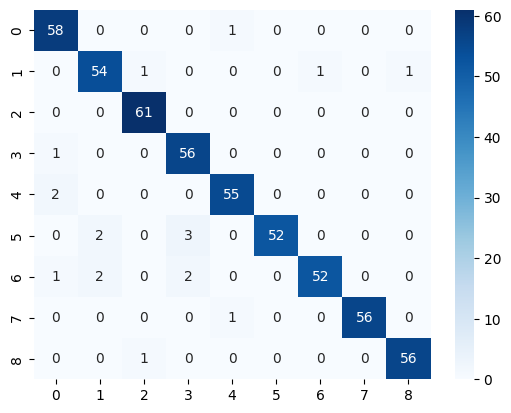

In [17]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_ds], axis=1)

labels = np.argmax(results[0], axis=1)
predictions = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

#disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
#disp.plot()

print(classification_report(labels, predictions, digits = 4))
# Las filas de la salida representan los valores reales
# Las columnas de la salida reepresentan los valores predichos por la red
# Valores de precisón, recall y f1 con respecto a TruePositive, FalsePositve, TrueNegative y FalseNegative
# precison=TP/(TP+FP)
# recall=TP/(TP+FN)
# f1=(2*precision*recall)/(precision+recall)

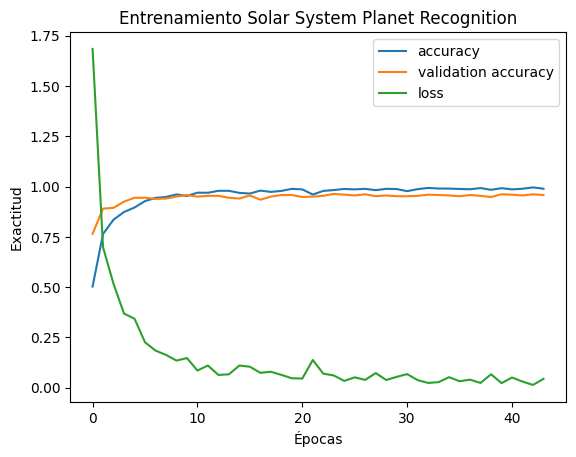

In [18]:
# Analizamos la anterior variable history
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['loss'], label='loss')

plt.title('Entrenamiento Solar System Planet Recognition')

plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend(loc="upper right")

plt.show()
# Gráfica que representa la perdida, efectividad y efectividad en validación de nuestra red,
# con sensibilidad en la excactitud según se van sucediendo las épocas
# Si las dos curvas de efectividad son cercanas a 1 y entre si todo va bien

(250, 250, 3)
1/1 [==============================] - 0s 21ms/step
El vector de salida obtenido:  [[1.3450524e-10 1.4034923e-07 5.3379128e-12 7.8275222e-03 9.4349062e-09
  9.9217236e-01 3.9380708e-08 9.2632030e-10 5.4975591e-10]]
1/1 [==============================] - 0s 20ms/step
La etiqueta de salida predicha es  5
1/1 [==============================] - 0s 20ms/step
Ahora dicho con texto: La etiqueta de salida predicha es  pluto


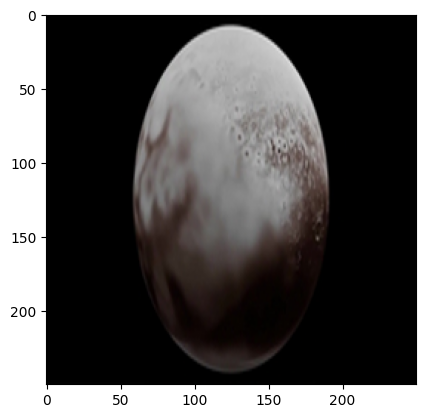

In [21]:
# PRODUCTION ----------------------------------------------

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import tensorflow.keras

# LOADING --------------------------------------------------
# model = tensorflow.keras.models.load_model("/kaggle/input/solar-system-planets-model/mi_modelo_v10.h5")

etiquetas=["earth", "jupiter", "mars", "mercury", "neptune", "pluto", "saturn", "uranus", "venus"]
%matplotlib inline

pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/planetsdataset_completo/test/pluto/pluto (50).jpg', 'r')
im = np.asarray(pil_im.resize((250, 250)))
imshow(im)
print(im.shape) # La imagen es un array de dimensión: 250x250x3

# El método `predict` hace la predicción de un lote de entradas, no solo una.
# En el caso de que tengamos solo una entrada deberemos añadirle una dimensión más
# al array numpy para que la entrada tenga la dimensión: 1x250x250x3

im = im.reshape(1,250,250,3)


print('El vector de salida obtenido: ', model.predict(im))
print('La etiqueta de salida predicha es ', np.argmax(model.predict(im)))
print('Ahora dicho con texto: La etiqueta de salida predicha es ', etiquetas[np.argmax(model.predict(im))])


# Hacemos una comprobación con una muestra aleatoria del conjunto de test



In [23]:
# PRODUCTION ----------------------------------------------

#from matplotlib.pyplot import imshow
import numpy as np
#from PIL import Image
import tensorflow.keras

# SAVING --------------------------------------------------
#model.save_model("mimodelo.h5")


# LOADING --------------------------------------------------
# model = tensorflow.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/modelos/mi_modelo_v10.h5")

etiquetas=["earth", "jupiter", "mars", "mercury", "neptune", "pluto", "saturn", "uranus", "venus"]
%matplotlib inline
print("ETIQUETA PREDICHA -> ETIQUETA REAL")
for minilote in test_ds:
    prediccion_minilote = model.predict(minilote[0].numpy())
    etiqueta_real_minilote = minilote[1].numpy()
    for y_predicha, y_real in zip(np.round(prediccion_minilote,3), etiqueta_real_minilote):
        if np.argmax(y_predicha) == np.argmax(y_real):   # Si el valor predicho es igual al valor real
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)])
        else:   # Si el valor predicho NO es igual al valor real ponemos una X para identificar el error más facilmente
            print(etiquetas[np.argmax(y_predicha)], "->", etiquetas[np.argmax(y_real)], "✘")

# Hacemos la prueba final pasando a la red todo el conjunto de test

ETIQUETA PREDICHA -> ETIQUETA REAL
1/1 [==============================] - 0s 33ms/step
venus -> venus
mars -> venus ✘
neptune -> neptune
uranus -> uranus
earth -> earth
venus -> venus
neptune -> neptune
jupiter -> jupiter
earth -> earth
neptune -> neptune
mercury -> mercury
mars -> mars
saturn -> saturn
pluto -> jupiter ✘
jupiter -> jupiter
saturn -> saturn
venus -> venus
venus -> venus
neptune -> neptune
pluto -> pluto
neptune -> neptune
uranus -> uranus
earth -> earth
pluto -> pluto
uranus -> uranus
saturn -> saturn
saturn -> saturn
jupiter -> saturn ✘
jupiter -> saturn ✘
earth -> earth
pluto -> pluto
jupiter -> jupiter
1/1 [==============================] - 0s 31ms/step
jupiter -> jupiter
pluto -> pluto
uranus -> uranus
mars -> mars
mercury -> mercury
earth -> earth
jupiter -> jupiter
mercury -> jupiter ✘
jupiter -> jupiter
earth -> earth
venus -> venus
uranus -> uranus
neptune -> neptune
mars -> mars
mercury -> jupiter ✘
jupiter -> saturn ✘
earth -> earth
mercury -> mercury
mars ->